In [1]:
import os
from tqdm import tqdm
from time import time
import pandas as pd
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit, Aer, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import StabilizerState, Pauli, DensityMatrix, Statevector, Operator
from qiskit.quantum_info.operators.symplectic.clifford import Clifford
from qiskit.circuit.quantumcircuitdata import CircuitInstruction
from qiskit.circuit.operation import Operation
from qiskit_aer import aerbackend, aerprovider
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, QuantumError, pauli_error
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
from collections import defaultdict
from qiskit.quantum_info import state_fidelity
np.random.seed(239)
import seaborn as sns
directory_path='QASMBench/'

In [2]:
native_gates = ['rz', 'cz', 'rx']

In [3]:
def remove_conditions(circuit : QuantumCircuit):
    circ = QuantumCircuit(*circuit.cregs, *circuit.qregs)
    circ.name = circuit.name
    for instr, qargs, cargs in circuit.data:
        if (instr.condition is None):
            circ.append(instr, qargs, cargs)
    return circ

In [4]:
def normalize_angle(angle):
    normalized_angle = angle % (2 * np.pi)
    if normalized_angle < 0:
        normalized_angle += 2 * np.pi   
    return normalized_angle

In [26]:
def round_to_pi2(angle):
    normalized_angle = normalize_angle(angle)
    rounded_angle = int(normalized_angle // (np.pi / 2)) * (np.pi / 2)
    return rounded_angle

def round_angles(circuit):
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    angle = 0
    for instr, qargs, cargs in circuit.data:
        if (instr.name == 'rz'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.rz(angle, qargs) if angle else 0
        elif(instr.name == 'rx'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.rx(angle, qargs) if angle else 0
        elif(instr.name == 'ry'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.ry(angle, qargs) if angle else 0
        else:
            new_circuit.append(instr, qargs, cargs)
    return new_circuit

In [6]:
def get_duration_prob(name, params, T2=2000, T_RX=100, T_RZ=30, T_CZ=15): #mks
    if (name == 'rx' or name == 'ry'):
        theta = params[0] % (2 * np.pi)
        return theta / np.pi * 5, 1 - np.exp(-theta / T_RX / np.pi)
    if (name == 'rz'):
        theta = params[0] % (2 * np.pi)
        return theta / np.pi * 0.5, 1 - np.exp(-theta / T_RZ / np.pi)
    if (name == 'cz'):
        return 2, 1 - np.exp(-2. / T_CZ)
    if (name == 'id'):
        if len(params):
            t = params[0]
            return t, 1 - np.exp(-t/T2)
        return 0, 1
    return None

def make_native_circuit(t_circ : QuantumCircuit, opt_level=0, T2=2000, T_RX=100, T_RZ=30, T_CZ=15) -> (QuantumCircuit, dict):
    circuit = transpile(t_circ, basis_gates=native_gates, optimization_level=opt_level)
    time = 0.0 #mks
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    new_circuit.name = t_circ.name
    data = []
    num_instr = 0
    times = np.zeros(circuit.num_qubits)
    for instr, qargs, cargs in circuit.data:
        if (instr.name in native_gates):
            for qarg in qargs:
                index = circuit.find_bit(qarg).index     
                # id gate:
                if times[index] != time:
                    new_circuit.id(qarg)
                    duration_id, prob_id = get_duration_prob('id', [time - times[index]], T2=T2)
                    data.append(prob_id)
                    times[index] = time
            # gate:
            duration, prob = get_duration_prob(instr.name, instr.params, T2=T2, T_RX=T_RX, T_RZ=T_RZ, T_CZ=T_CZ)
            new_circuit.append(instr, qargs, cargs)
            data.append(prob)
            time = time + duration
            for qarg in qargs:
                times[index] = time
    for qreg in new_circuit.qregs:
        for qarg in qreg:
            index = new_circuit.find_bit(qarg).index
            if times[index] != time:
                new_circuit.id(qarg)
                duration, prob = get_duration_prob('id', [time - times[index]], T2=T2)
                data.append(prob)        
    return new_circuit, data

In [7]:
def noisy_circuit(circuit, data):
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    assert(len(circuit.data) == len(data))
    for i, (instr, qargs, cargs) in enumerate(circuit.data):
        prob_error = data[i]
        choice = np.random.choice(['Z', 'I'], p=[prob_error, 1 - prob_error])
        new_circuit.append(instr, qargs, cargs)
        if (choice == 'Z'):
            new_circuit.z(qargs)
    return new_circuit

In [8]:
def make_clifford_data(circ : QuantumCircuit, data : list = None, round_angle : bool =False):
    if not round_angle or not data:
        c, data = make_native_circuit(round_angles(circ), opt_level=0)
    else:
        c = circ
    new_circuit = QuantumCircuit(*c.qregs, *c.cregs)
    new_data = []
    for i, (instr, qargs, cargs) in enumerate(c.data):
        if (instr.name == 'rz'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.s(qargs)
                new_data.append(data[i])
            elif (angle == np.pi):
                new_circuit.z(qargs)
                new_data.append(data[i])
            elif (angle == 3 * np.pi / 2):
                new_circuit.s(qargs)
                new_circuit.z(qargs)
                new_data.append(0)
                new_data.append(data[i])
        elif (instr.name == 'rx'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
            elif (angle == np.pi):
                new_circuit.x(qargs)
                new_data.append(data[i])
            elif (angle == 3 * np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.x(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
        elif (instr.name == 'ry'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
            elif (angle == np.pi):
                new_circuit.y(qargs)
                new_data.append(data[i])
            elif (angle == 3 * np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.y(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
        else:
            new_circuit.append(instr, qargs, cargs)
            new_data.append(data[i])
    return new_circuit, new_data

In [9]:
def make_clifford(circ : QuantumCircuit, round_angle : bool =False) -> Clifford:
    if not round_angle:
        transpile_circuit = round_angles(circ)
    else:
        transpile_circuit = circ
    new_circuit = QuantumCircuit(*transpile_circuit.qregs, *transpile_circuit.cregs)
    close = lambda a, b : np.abs(a - b) < 1e-6
    for instr, qargs, cargs in transpile_circuit.data:
        if (instr.name == 'rz'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.z(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.s(qargs)
                new_circuit.z(qargs)
        elif (instr.name == 'rx'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
            elif (angle == np.pi):
                new_circuit.x(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.x(qargs)
        elif (instr.name == 'ry'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.y(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.y(qargs)
        else:
            new_circuit.append(instr, qargs, cargs)
    new_circuit.save_clifford()
    aer = AerSimulator(method='stabilizer')
    result = aer.run(new_circuit, shots=1).result().data()['clifford']
    return result, new_circuit

In [10]:
paths = []
for root, dirs, files in os.walk(directory_path):
    for dir_name in dirs:
        qasm_file_path = os.path.join(directory_path, dir_name, f"{dir_name}.qasm")
        number_at_end = int(''.join(filter(str.isdigit, dir_name)))
        if os.path.exists(qasm_file_path) and number_at_end <= 7:
            paths.append(qasm_file_path)

In [11]:
data_circuits = []
circuits = []
for i, path in enumerate(paths):    
    filename = path.split('/')[-1]
    sys.stdout.flush()
    circuit = QuantumCircuit.from_qasm_file(path)
    circuit.name = filename[:-5]
    circuit = remove_conditions(circuit)
    circuit.remove_final_measurements()
    circuit2 = transpile(circuit, optimization_level=0, basis_gates=native_gates)
    circuit2.name = circuit.name
    circuits.append(circuit2)
    data_circuits.append(make_native_circuit(circuit, opt_level=0))

In [12]:
circuits[0].name

'qft_n4'

In [39]:
noise_model = aerbackend.NoiseModel()
p_gate1 = 0.005
error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
noise_model.add_all_qubit_quantum_error(error_gate1, ["rx", "rz"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cz"])
d = noise_model.to_dict()

In [46]:
1 - p_gate1**2 - 2* p_gate1*(1-p_gate1)

0.9900249999999999

In [40]:
d['errors']

[{'type': 'qerror',
  'id': '7030887b95804fafa574a81e25e24db6',
  'operations': ['rx'],
  'instructions': [[{'name': 'z', 'qubits': [0]}],
   [{'name': 'id', 'qubits': [0]}]],
  'probabilities': [0.005, 0.995]},
 {'type': 'qerror',
  'id': '7030887b95804fafa574a81e25e24db6',
  'operations': ['rz'],
  'instructions': [[{'name': 'z', 'qubits': [0]}],
   [{'name': 'id', 'qubits': [0]}]],
  'probabilities': [0.005, 0.995]},
 {'type': 'qerror',
  'id': '7015865de9f34103a83a005b33d60829',
  'operations': ['cz'],
  'instructions': [[{'name': 'z', 'qubits': [0]},
    {'name': 'z', 'qubits': [1]}],
   [{'name': 'id', 'qubits': [0]}, {'name': 'z', 'qubits': [1]}],
   [{'name': 'z', 'qubits': [0]}, {'name': 'id', 'qubits': [1]}],
   [{'name': 'id', 'qubits': [0]}, {'name': 'id', 'qubits': [1]}]],
  'probabilities': [2.5e-05, 0.004975, 0.004975, 0.990025]}]

In [13]:
def fidelity_clifford_long(clifford1 : Clifford, clifford2 : Clifford) -> complex:
    d = 2 ** clifford1.num_qubits
    initial_state = np.zeros(d)
    initial_state[0] = 1
    initial_state = initial_state.reshape(d, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state2 = clifford2.to_matrix() @ initial_state
    return state_fidelity(state1, state2)

In [14]:
#to plot circuits
#plt.figure(figsize=(100, 5))
# circ, d = make_native_circuit(round_angles(circuits[12][0]), opt_level=0)
# n_circ = noisy_circuit(circ, d)
# fig, axs = plt.subplots(3, 1, figsize=(100, 8), gridspec_kw={'hspace': 0.001})
# circuit_drawer(circuits[12][0], output='mpl', style='iqp', ax=axs[0], scale=2, fold=len(circuits[12][0].data))
# circuit_drawer(circ, output='mpl', style='clifford', ax=axs[1], scale=2, fold=len(circuits[12][0].data))
# circuit_drawer(n_circ, output='mpl', style='clifford', ax=axs[2], scale=2, fold=len(n_circ.data))
# plt.savefig('circ12.pdf')


In [15]:
#to check (measuring -> measure = True)
def fidelity_density_matrix_orig(circuit :QuantumCircuit, T2=2000, T_RX=100, T_RZ=30, T_CZ=15, measure=True):
    circ, d = make_native_circuit(circuit, opt_level=0, T2=T2, T_RX=T_RX, T_RZ=T_RZ, T_CZ=T_CZ)
    noiseless_circ = circ.copy()
    noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    rho1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().data()['density_matrix'])
    

    rho2 = np.zeros_like(rho1)
    rho2[0, 0] = 1
    for i, (instr, qargs, cargs) in enumerate(circ.data):
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.append(instr, qargs, cargs)
        U = Operator(qc).to_matrix()
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.z(qargs)
        Z = Operator(qc).to_matrix()
        rho2 = U @ rho2 @ U.T.conj()
        prob = d[i]
        #rho2 = (1 - prob) * rho2 + prob * np.eye(2 ** circ.num_qubits) / (2 ** circ.num_qubits)
        rho2 = (1 - prob) * rho2 + prob * Z @ rho2 @ Z
    if measure:
        return state_fidelity(np.diag(rho1.diagonal()), np.diag(rho2.diagonal()))
    else:
        return state_fidelity(rho1, rho2)

In [16]:
def fidelity_density_matrix_clifford(circuit :QuantumCircuit, T2=2000, T_RX=100, T_RZ=30, T_CZ=15, measure=True):
    circ, d = make_clifford_data(circuit)
    noiseless_circ = circ.copy()
    noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    rho1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().data()['density_matrix'])
    

    rho2 = np.zeros_like(rho1)
    rho2[0, 0] = 1
    for i, (instr, qargs, cargs) in enumerate(circ.data):
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.append(instr, qargs, cargs)
        U = Operator(qc).to_matrix()
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.z(qargs)
        Z = Operator(qc).to_matrix()
        rho2 = U @ rho2 @ U.T.conj()
        prob = d[i]
        #rho2 = (1 - prob) * rho2 + prob * np.eye(2 ** circ.num_qubits) / (2 ** circ.num_qubits)
        rho2 = (1 - prob) * rho2 + prob * Z @ rho2 @ Z
    if measure:
        return state_fidelity(np.diag(np.abs(rho1.diagonal())), np.diag(np.abs(rho2.diagonal())))
    else:
        return state_fidelity(rho1, rho2)

In [27]:
def fidelity_measuring(circuit : QuantumCircuit, shots=1000):
    t = time()
    #c, d = make_clifford_data(round_angles(circuit))
    c, d = make_native_circuit(round_angles(circuit))
    print("MAKE_DATA:", time() - t)
    t1 = time() - t
    noiseless = c.copy()
    noiseless.measure_all()
    g = AerSimulator(method='stabilizer')
    t = time()
    result1 = dict(g.run(noiseless, noise_model=None, shots=shots, optimization_level=0).result().data())['counts']
    print("NOISELESS:", time() - t)
    sys.stdout.flush()
    t2 = time() - t
    noisies = []
    result2 = defaultdict(int)
    #for _ in tqdm(range(shots)):
    t = time()
    for _ in range(shots):
        noisy = noisy_circuit(c, d)
        noisy.measure_all()
        noisies.append(noisy)
    print("NOISY CIRCUIT:", time() - t)
    t4 = time() - t
    #noise_model = aerbackend.NoiseModel()
    #p_gate1 = 0.005
    #error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
    #error_gate2 = error_gate1.tensor(error_gate1)
    #noise_model.add_all_qubit_quantum_error(error_gate1, ["rx", "rz"])
    #noise_model.add_all_qubit_quantum_error(error_gate2, ["cz"])
    t = time()
    results = g.run(noisies, noise_model=None, shots=1, optimization_level=0).result()
    #result2 = dict(g.run(noiseless, noise_model=noise_model, shots=shots, optimization_level=0).result().data())['counts']
    print("NOISY", shots, ":", time() - t)
    t3 = time() - t
    for i in range(shots):
        res = list(results.data(i)['counts'])[0]
        result2[res] += results.data(i)['counts'][res]
    df = pd.DataFrame([result1, result2]).T
    df = df.fillna(0).astype(int)
    state1 = np.array(np.sqrt(df[0] / shots))
    state2 = np.array(np.sqrt(df[1] / shots))
    return state_fidelity(state1, state2), t2, t3
    #return (np.sum(np.sqrt(df[0] * df[1])) / shots) ** 2

In [28]:
def circuit_test(d = 500, n = 5):
    res = QuantumCircuit(n)
    for _ in range(d):
        for k in range(n - 1):
            res.cx(k, k + 1)
            res.rx(np.pi * 9 / 8, k)
            res.rx(np.pi / 9, k + 1)
    return res

In [30]:
c = circuit_test(500, 9)
fidelity_measuring(c, shots=32)

MAKE_DATA: 0.6258912086486816
NOISELESS: 0.22950983047485352
NOISY CIRCUIT: 15.340909957885742
NOISY 32 : 7.492256164550781


(0.03125000000000001, 0.22986912727355957, 7.492337226867676)

In [103]:
np.pi

3.141592653589793

In [32]:
fs2 = []

In [33]:
for n in range(1, 10):
    shots = 32
    print("------N: ", n, "-----")
    c = circuit_test(500, n)
    fs2.append(fidelity_measuring(c, shots))

------N:  1 -----
MAKE_DATA: 0.00506901741027832
NOISELESS: 0.002160787582397461
NOISY CIRCUIT: 0.0033540725708007812
NOISY 32 : 0.005012989044189453
------N:  2 -----
MAKE_DATA: 0.07296490669250488
NOISELESS: 0.02896714210510254
NOISY CIRCUIT: 1.8928680419921875
NOISY 32 : 0.9181580543518066
------N:  3 -----
MAKE_DATA: 0.13141202926635742
NOISELESS: 0.05735421180725098
NOISY CIRCUIT: 3.945404291152954
NOISY 32 : 1.801285743713379
------N:  4 -----
MAKE_DATA: 0.197343111038208
NOISELESS: 0.09001803398132324
NOISY CIRCUIT: 5.762141227722168
NOISY 32 : 2.8235769271850586
------N:  5 -----
MAKE_DATA: 0.31447410583496094
NOISELESS: 0.11329412460327148
NOISY CIRCUIT: 8.137017726898193
NOISY 32 : 3.7525391578674316
------N:  6 -----
MAKE_DATA: 0.33103227615356445
NOISELESS: 0.1433851718902588
NOISY CIRCUIT: 9.68446159362793
NOISY 32 : 4.720247745513916
------N:  7 -----
MAKE_DATA: 0.3971672058105469
NOISELESS: 0.17548203468322754
NOISY CIRCUIT: 11.586826086044312
NOISY 32 : 5.69209814071655

In [516]:
fs2[1]

(0.53125, 0.09954714775085449, 0.02834606170654297, 0.8792240619659424)

In [517]:
make_datas = [f[1] for f in fs2]
noisy_circuit = [0.003002166748046875, 1.958348035812378, 4.578641176223755, 7.105705261230469, 9.62247085571289, 11.920506238937378, 14.44860315322876, 16.75915813446045, 18.804713010787964]
noisy_32 = [f[-1] for f in fs2]
ns = np.arange(1, 10)

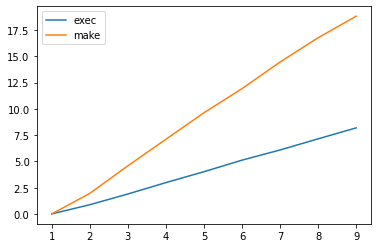

In [518]:
plt.plot(ns, noisy_32, label = 'exec')
plt.plot(ns, noisy_circuit, label = 'make')
plt.legend()

In [482]:
c = circuit_test(100, 5)

In [490]:
shots = 1
fs = []
while shots < 15000:
    print("------SHOTS: ", shots, "-----")
    fs.append(fidelity_measuring(c, shots))
    shots *= 2
    shots = int(shots)

------SHOTS:  1 -----
MAKE_DATA: 0.3853001594543457
NOISELESS: 0.12189984321594238
NOISY 1 : 0.12358331680297852
------SHOTS:  2 -----
MAKE_DATA: 0.3541378974914551
NOISELESS: 0.12212991714477539
NOISY 2 : 0.24852204322814941
------SHOTS:  4 -----
MAKE_DATA: 0.3556840419769287
NOISELESS: 0.12139892578125
NOISY 4 : 0.49673962593078613
------SHOTS:  8 -----
MAKE_DATA: 0.356475830078125
NOISELESS: 0.12178421020507812
NOISY 8 : 1.0428826808929443
------SHOTS:  16 -----
MAKE_DATA: 0.35869526863098145
NOISELESS: 0.12502217292785645
NOISY 16 : 1.9934160709381104
------SHOTS:  32 -----
MAKE_DATA: 0.3567931652069092
NOISELESS: 0.12160706520080566
NOISY 32 : 3.9503772258758545
------SHOTS:  64 -----
MAKE_DATA: 0.3575599193572998
NOISELESS: 0.12172389030456543
NOISY 64 : 7.9190897941589355
------SHOTS:  128 -----
MAKE_DATA: 0.3719978332519531
NOISELESS: 0.12352776527404785
NOISY 128 : 15.733317136764526
------SHOTS:  256 -----
MAKE_DATA: 0.35533595085144043
NOISELESS: 0.12300276756286621
NOISY 25

KeyboardInterrupt: 

In [473]:
fidelity_measuring(circuits[12])

MAKE_DATA: 0.11986017227172852
NOISELES: 0.018975257873535156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.27it/s]


NOISY SHOTS: 15.561654090881348


0.21306230322865663

In [46]:
def clifford_simulate(circ :  QuantumCircuit) -> Clifford:
    circuit = circ.copy()
    circuit.save_clifford()
    aer = AerSimulator(method='stabilizer')
    result = aer.run(circuit, shots=1).result().data()['clifford']
    return result

In [47]:
def fidelity(circuit : QuantumCircuit, shots=1000):
    circ, d = make_native_circuit(round_angles(circuit), opt_level=0)
    clifford1, c = make_clifford(circ, round_angle=True)
    fs = []
    clifford2 = 0
    r = 2 ** clifford1.num_qubits
    initial_state = np.zeros(r)
    initial_state[0] = 1
    initial_state = initial_state.reshape(r, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state_all = np.zeros_like(state1)
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(circ, d)
        clifford2, c = make_clifford(noisy, round_angle=True)
        state2 = clifford2.to_matrix() @ initial_state
        state_all += np.abs(state2)**2
        #fs.append(state_fidelity(state1, state2))
    state_all = np.sqrt(state_all / shots)
    #return np.mean(fs), 
    return state_fidelity(state_all, np.abs(state1))

In [48]:
def fidelity2(circuit : QuantumCircuit, shots=1000):
    circ, d = make_clifford_data(circuit)
    clifford1 = clifford_simulate(circ)
    fs = []
    clifford2 = 0
    noisies = []
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(circ, d)
        noisy.save_clifford()
        noisies.append(noisy)
    g = AerSimulator(method='stabilizer')
    result = g.run(noisies, shots=1).result()#.data()['clifford']
    d = 2 ** clifford1.num_qubits
    initial_state = np.zeros(d)
    initial_state[0] = 1
    initial_state = initial_state.reshape(d, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state_all = np.zeros_like(state1)
    for i in tqdm(range(shots)):
        clifford2 = result.data(i)['clifford']
        state2 = clifford2.to_matrix() @ initial_state
        state_all += np.abs(state2)**2
        #fs.append(state_fidelity(state1, state2))
    state_all = np.sqrt(state_all / shots)
    #return np.mean(fs), 
    return state_fidelity(state_all, np.abs(state1))

In [33]:
data = []

def sorting_key(qc):
    return (qc[0].num_qubits, len(qc[0]))

data_circuits_sorted = sorted(data_circuits, key=sorting_key)
shots = 10
for circuit, d in datacircuits_sorted:
    print('\\')
    print(circuit.name)
    shots = 10
    eps = 1
    fid1 = fidelity_density_matrix(round_angles(circuit), measure=True)
    while shots < 2000:
        epses = []
        k = 0
        while (k < 3):
            fid2 = fidelity_measuring(circuit, shots=shots)
            data.append({'circuit' : circuit.name, 
                   'orig_fidelity' : fid1, 
                   'clifford_fidelity' : fid2, 
                    'shots': shots})
            eps = np.abs(fid2 - fid1) / fid1
            epses.append(eps)
            #print(shots, circuit.name, fid1, fid2, eps)
            print(shots, end= ',')
            k += 1
        eps = np.max(epses) if len(epses) else eps
        shots = int(shots * 1.3)

In [802]:
def fidelity_measuring2(circuit : QuantumCircuit, shots=1000):
    c, d = make_native_circuit(round_angles(circuit), opt_level=0)
    noiseless = c.copy()
    noiseless.measure_all()
    #clifford1 = make_cliffor
    #noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    result1 = dict(g.run(noiseless, noise_model=None, shots=shots, optimization_level=0).result().data())['counts']   
    noisies = []
    result2 = defaultdict(int)
    #for _ in tqdm(range(shots)):
    for _ in range(shots):
        noisy = noisy_circuit(c, d)
        noisy.measure_all()
        noisies.append(noisy)
    results = g.run(noisies, noise_model=None, shots=1, optimization_level=0).result()
    for i in range(shots):
        res = list(results.data(i)['counts'])[0]
        result2[res] += results.data(i)['counts'][res]
    df = pd.DataFrame([result1, result2]).T
    df = df.fillna(0).astype(int)
    state1 = np.array(np.sqrt(df[0] / shots))
    state2 = np.array(np.sqrt(df[1] / shots))
    return state_fidelity(state1, state2)
    #return (np.sum(np.sqrt(df[0] * df[1])) / shots) ** 2

In [458]:
def error_log_prob(circuit : QuantumCircuit):
    c, d = make_native_circuit(circuit, opt_level=0)
    res = 0
    for prob in d:
        if not prob is None:
            res += np.log(prob)
    return res

In [57]:
df = pd.DataFrame(data)
df['qubit_count'] = df['circuit'].apply(lambda c: int(c[-1]))
df['eps'] = np.abs(df['orig_fidelity'] - df['clifford_fidelity']) / df['orig_fidelity']
lens = {c.name : len(c) for c, t in circuits_sorted}
circs = {c.name : c for c, t in circuits_sorted}
def peaks(c1 : QuantumCircuit):
    c = c1.copy()
    g = AerSimulator()
    c.measure_all()
    return len(g.run(c, shots=2000).result().data()['counts'])
peakss = {c.name: peaks(c) for c, t in circuits_sorted}
df['len'] = df['circuit'].apply(lambda c: lens[c])
df['peaks'] = df['circuit'].apply(lambda c: peakss[c])

,circuit,orig_fidelity,clifford_fidelity,shots,qubit_count,eps,len,peaks
0,deutsch_n2,0.861497,0.827047,100,2,0.039988,13,2
1,deutsch_n2,0.861497,0.869959,100,2,0.009822,13,2
2,deutsch_n2,0.861497,0.813100,100,2,0.056178,13,2
3,deutsch_n2,0.861497,0.838295,130,2,0.026932,13,2
4,deutsch_n2,0.861497,0.828231,130,2,0.038615,13,2
...,...,...,...,...,...,...,...,...
2569,hhl_n7,0.500000,0.110079,62,7,0.779842,814,5
2570,hhl_n7,0.500000,0.096073,62,7,0.807853,814,5
2571,hhl_n7,0.500000,0.109808,80,7,0.780384,814,5
2572,hhl_n7,0.500000,0.142431,80,7,0.715138,814,5


In [56]:
data = data + data2

In [464]:
plt.figure(figsize=(30, 10))
df['shots_on_peak'] = df['shots'] / df['peaks']
g = sns.relplot(x='shots', y='eps', hue='circuit', kind='line', data=df, palette='dark', alpha=0.5)

g.set_axis_labels('shots', 'eps')
g.set_titles(col_template='{col_name}')
plt.hlines(y=0.1, xmin=100, xmax=2000, color='black')
plt.xscale('log')
plt.show()

NameError: name 'df' is not defined

<Figure size 2160x720 with 0 Axes>

In [34]:
def my_circuit() -> QuantumCircuit:
    c = QuantumCircuit(3)
    c.cz(0, 1)
    c.cz(0, 1)
    c.cz(0, 1)
    c.rz(np.pi, 2)
    c.cz(1, 0)
    c.cz(0, 1)
    c.rz(np.pi, 2)
    c.rz(np.pi, 2)
    c.rx(np.pi, 1)
    c.cz(1, 2)
    c.rz(np.pi, 0)
    c.cz(0, 1)
    c.cz(2, 1)
    c.rx(np.pi, 1)
    c.cz(0, 1)
    c.rz(np.pi, 2)
    c.rx(np.pi, 1)
    c.cz(0, 1)
    c.rz(np.pi, 1)
    c.rx(np.pi, 2)
    c.cz(0, 1)
    c.cz(1, 2)
    c.cz(2, 1)
    c.cz(1, 2)
    c.cz(0, 1)
    c.cz(0, 1)
    return c

In [66]:
fidelity_long_shots_2(round_angles(circuits[12][0]), shots=5000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.56it/s]


0.5142000000000008

In [67]:
fidelity(round_angles(circuits[12][0]), shots=5000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:04<00:00, 10.32it/s]


0.4997999999999998

In [175]:
c = QuantumCircuit(1)
c.x(0)
c.z(0)
d1 = Operator(c).to_matrix()

c = QuantumCircuit(1)
c.z(0)
c.x(0)
d2 = Operator(c).to_matrix()

In [176]:
i_state = np.ones(2**1) / np.sqrt(2**1)
print(state_fidelity(d1 @ i_state.T, d2 @ i_state.T))
print(d1@d2 - d2@d1 == np.zeros_like(d2))
print(d1@d2 + d2@d1 == np.zeros_like(d2))

0.9999999999999996
[[ True  True]
 [ True  True]]
[[False  True]
 [ True False]]


In [169]:
d1 @ i_state.T

array([0.25622563-0.65905116j, 0.70357419+0.07059289j])

In [170]:
d2 @ i_state.T

array([0.60282587-0.48199139j, 0.51738216+0.36959568j])

In [139]:
print(d1@d2)

0.9907464631443117

In [35]:
c = my_circuit()
c.draw(fold=500)

┌───────┐                                                                  
q_0: ────■────────■────────■─────■──■─┤ Rz(π) ├────■─────────────────■──────────────■───────────■───────────■──■─
         │        │        │     │  │ ├───────┤    │    ┌───────┐    │    ┌───────┐ │ ┌───────┐ │           │  │ 
q_1: ────■────────■────────■─────■──■─┤ Rx(π) ├─■──■──■─┤ Rx(π) ├────■────┤ Rx(π) ├─■─┤ Rz(π) ├─■──■──■──■──■──■─
     ┌───────┐┌───────┐┌───────┐      └───────┘ │     │ ├───────┤┌───────┐└───────┘   └───────┘    │  │  │       
q_2: ┤ Rz(π) ├┤ Rz(π) ├┤ Rz(π) ├────────────────■─────■─┤ Rz(π) ├┤ Rx(π) ├─────────────────────────■──■──■───────
     └───────┘└───────┘└───────┘                        └───────┘└───────┘

In [149]:
from abc import ABC, abstractmethod
class Transformer(ABC):
    @abstractmethod
    def find(self, qc : QuantumCircuit) -> list:
        pass

    @abstractmethod
    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) ->QuantumCircuit:
        pass

In [150]:
def merge_cz(qc : QuantumCircuit, inplace=False)->QuantumCircuit:
    """
    ───@──@──   ───
       |  |   ≡               
    ───@──@──   ───
    """
    circuit = qc
    if not inplace:
        circuit = qc.copy()
    for i, instr1 in enumerate(circuit):
        remove_index = None
        if (instr1.operation.name == 'cz'):
            q1, q2 = instr1.qubits
            for j, instr2 in enumerate(circuit[i + 1:]):
                if (instr2.operation.name == 'cz'):
                    g1, g2 = instr2.qubits
                    if (q1, q2) == (g1, g2) or (q2, q1) == (g1, g2): 
                        remove_index = i + j + 1
                        break
                if q1 in list(instr2.qubits) or q2 in list(instr2.qubits):
                    break
        if remove_index is not None:
            circuit.data.pop(i)
            circuit.data.pop(i + j)
    return circuit

In [151]:
class X_CZ_to_CZ_X_Z(Transformer):
    """
    ───X───@───      ───@──X────
           |     ≡      |       
    ───────@───      ───@────Z──
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc
        result = []
        for i, instr1 in enumerate(circuit):
            indexes = None
            if (instr1.operation.name == 'rx' and np.abs(instr1.operation.params[0] - np.pi) < 1e-6):
                q_x = instr1.qubits[0]
                for j, instr2 in enumerate(circuit[i + 1:]):
                    if q_x in list(instr2.qubits):
                        if (instr2.operation.name == 'cz'):
                            indexes = i, i + j + 1
                        break
            if indexes is not None:
                result.append(indexes)
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) -> QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_x, index_cz = indexes
        assert(circuit[index_x].operation.name == 'rx')
        assert(circuit[index_cz].operation.name == 'cz')
        q_x = circuit[index_x].qubits[0]
        qs = circuit[index_cz].qubits
        assert (q_x in list(qs))
        q_z = qs[1] if qs[0] == q_x else qs[0]
        circuit.rx(np.pi, q_x)
        circuit.rz(np.pi, q_z)
        circuit.data.insert(index_cz + 1, circuit[-2])
        circuit.data.insert(index_cz + 1, circuit[-1])
        circuit.data.pop(index_x)
        circuit.data = circuit.data[:-2]
        return circuit

class CZ_X_to_X_Z_CZ(X_CZ_to_CZ_X_Z):
    """
    ────@─────X─      ───X───@───────
        |         ≡          |       
    ────@───────      ─────Z─@──────
    """
    def find_cz_x(self, qc : QuantumCircuit) -> list:
        circuit = qc.copy()
        circuit.data = circuit.data[::-1]
        result = super().find(circuit)
        d = len(qc)
        for i in range(len(result)):
            index_x, index_cz = result[i]
            result[i] = d - 1 - index_x, d - 1 - index_cz
        return result

    def change_cz_x_to_x_z_cz(self, qc : QuantumCircuit, indexes : tuple, inplace=False) ->QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_x, index_cz = indexes
        circuit2 = qc.copy()
        circuit2.data = circuit2.data[::-1]
        d = len(circuit2)
        circuit2 = super().transform(circuit2, (d - 1 - index_x, d - 1 - index_cz), inplace=True)
        circuit.data = circuit2.data[::-1]
        return circuit
    
class CZ_X_Z_to_X_CZ(Transformer):
    """
    ───@──X────   ───X────@────
       |        ≡         |
    ───@────Z──   ────────@────
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc
        result = []
        for i, instr1 in enumerate(circuit):
            indexes = None
            if (instr1.operation.name == 'cz'):
                q1, q2 = instr1.qubits
                for j, instr2 in enumerate(circuit[i + 1:]):
                    if (instr2.operation.name == 'rx'
                        and np.abs(instr2.operation.params[0] - np.pi) < 1e-6
                        and instr2.qubits[0] in [q1, q2]):

                        q_x = instr2.qubits[0]
                        q_z = q2 if q_x == q1 else q1

                        for k, instr3 in enumerate(circuit[i + 1:]):
                            if q_z in list(instr3.qubits):
                                if (instr3.operation.name == 'rz'
                                    and np.abs(instr3.operation.params[0] - np.pi) < 1e-6):
                                    q_z = instr3.qubits[0]
                                    indexes = i, i + j + 1, i + k + 1
                                break
                        break
                    if (instr2.operation.name != 'rz' and (q1 in list(instr2.qubits) or q2 in list(instr2.qubits))):
                        break
            if indexes is not None:
                result.append(indexes)
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) -> QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_cz, index_x, index_z = indexes
        assert(circuit[index_x].operation.name == 'rx')
        assert(circuit[index_z].operation.name == 'rz')
        assert(circuit[index_cz].operation.name == 'cz')
        qs = circuit[index_cz].qubits
        assert (circuit[index_x].qubits[0] in list(qs) and circuit[index_z].qubits[0] in list(qs))

        q_x = circuit[index_x].qubits[0]
        circuit.rx(np.pi, q_x)
        if index_x < index_z:
            circuit.data.pop(index_z)
            circuit.data.pop(index_x)
        else:
            circuit.data.pop(index_x)
            circuit.data.pop(index_z)
        circuit.data.insert(index_cz, circuit[-1])
        circuit.data = circuit.data[:-1]
        return circuit

class X_Z_CZ_to_CZ_X(CZ_X_Z_to_X_CZ):
    """
    ─X──@──────   ───────@───X─
        |        ≡       |
    ──Z─@──────   ───────@────
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc.copy()
        circuit.data = circuit.data[::-1]
        result = super().find(circuit)
        d = len(qc)
        for i in range(len(result)):
            index_cz, index_x, index_z = result[i]
            result[i] = d - 1 - index_cz, d - 1 - index_x, d - 1 - index_z
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) ->QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_cz, index_x, index_z = indexes
        circuit2 = qc.copy()
        circuit2.data = circuit2.data[::-1]
        d = len(circuit2)
        circuit2 = super().transform(circuit2, (d - 1 - index_cz, d - 1 - index_x, d - 1 - index_z), inplace=True)
        circuit.data = circuit2.data[::-1]
        return circuit
    
class Z_CZ_to_CZ_Z(Transformer):
    """
    ───Z───@───      ───@───Z───
           |     ≡      |       
    ───────@───      ───@──────
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc
        result = []
        for i, instr1 in enumerate(circuit):
            indexes = None
            if (instr1.operation.name == 'rz' and np.abs(instr1.operation.params[0] - np.pi) < 1e-6):
                q_z = instr1.qubits[0]
                for j, instr2 in enumerate(circuit[i + 1:]):
                    if q_z in list(instr2.qubits):
                        if (instr2.operation.name == 'cz'):
                            indexes = i, i + j + 1
                        break
            if indexes is not None:
                result.append(indexes)
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) -> QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_z, index_cz = indexes
        assert(circuit[index_z].operation.name == 'rz')
        assert(circuit[index_cz].operation.name == 'cz')
        q_z = circuit[index_z].qubits[0]
        qs = circuit[index_cz].qubits
        assert (q_z in list(qs))
        circuit.rz(np.pi, q_z)
        circuit.data.insert(index_cz + 1, circuit[-1])
        circuit.data.pop(index_z)
        circuit.data = circuit.data[:-1]
        return circuit

class CZ_Z_to_Z_CZ(Z_CZ_to_CZ_Z):
    """
    ────@─────Z─      ───Z───@───────
        |         ≡          |       
    ────@───────      ───────@──────
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc.copy()
        circuit.data = circuit.data[::-1]
        result = super().find(circuit)
        d = len(qc)
        for i in range(len(result)):
            index_z, index_cz = result[i]
            result[i] = d - 1 - index_z, d - 1 - index_cz
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) ->QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_z, index_cz = indexes
        circuit2 = qc.copy()
        circuit2.data = circuit2.data[::-1]
        d = len(circuit2)
        circuit2 = super().transform(circuit2, (d - 1 - index_z, d - 1 - index_cz), inplace=True)
        circuit.data = circuit2.data[::-1]
        return circuit   

In [152]:
def merge_unitary(qc : QuantumCircuit, inplace=False)->QuantumCircuit:
    """
    ───RX(a)──RX(b)── ≡ ─RX(a + b)──
    
    ───RX(2pi)──      ≡ ────────────
    """
    circuit = qc
    if not inplace:
        circuit = qc.copy()
    ops = {q: [] for q in list(circuit.qubits)}
    for i, instr in enumerate(circuit):
        for q in list(instr.qubits):
            ops[q].append(i)
    drops = []
    swaps = [] #swap
    for q in ops:
        buf_i = None
        buf_name = None
        buf_angle = 0
        for k, i in enumerate(ops[q]):
            op = circuit[i]
            if ((not (buf_i is None)) and buf_name == op.operation.name):
                op.operation.params = [op.operation.params[0] + 0.0]
                angle = op.operation.params[0]
                drops.append(i)
                buf_angle += angle
            else:
                if not (buf_i is None):
                    buf_angle = normalize_angle(buf_angle)
                    if buf_name == 'rx':
                        circuit.rx(buf_angle, q)
                    else:
                        circuit.rz(buf_angle, q)
                    swaps.append((buf_i, len(circuit) - 1))
                    if (np.abs(buf_angle) < 1e-6 or np.abs(buf_angle - 2 * np.pi) < 1e-6):
                        drops.append(buf_i)
                buf_i, buf_angle, buf_name = (i, op.operation.params[0], op.operation.name) if (
                    op.operation.name in ['rx', 'rz']) else (None, 0, None)
            if (k == len(ops[q]) - 1):
                if not (buf_i is None):
                    buf_angle = normalize_angle(buf_angle)
                    if buf_name == 'rx':
                        circuit.rx(buf_angle, q)
                    else:
                        circuit.rz(buf_angle, q)
                    swaps.append((buf_i, len(circuit) - 1))
                    if (np.abs(buf_angle) < 1e-6 or np.abs(buf_angle - 2 * np.pi) < 1e-6):
                        drops.append(buf_i)
    for a, b in swaps:
        circuit.data[a], circuit.data[b] = circuit.data[b], circuit.data[a]
        drops.append(b)
    drops = sorted(drops)[::-1]
    for d in drops:
        circuit.data.pop(d)
    return circuit

In [154]:
def merge_unitary_hard(qc : QuantumCircuit, inplace=False)->QuantumCircuit:
    """
    ───RX(a)──RX(b)── ≡ ─RX(a + b)──
    
    ───RX(2pi)──      ≡ ────────────
    """
    circuit = qc
    if not inplace:
        circuit = qc.copy()
    ops = {q: [] for q in list(circuit.qubits)}
    for i, instr in enumerate(circuit):
        for q in list(instr.qubits):
            ops[q].append(i)
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    buf = {q: np.eye(2) for q in list(circuit.qubits)}
    for i, (instr, qargs, cargs) in enumerate(circuit.data):
        if instr.name in ['rx', 'rz']:
            buf[qargs[0]] = Operator(instr).to_matrix() @ buf[qargs[0]]
        else:
            u = {qarg: [] for qarg in qargs}
            for qarg in qargs:
                c = QuantumCircuit(1)
                c.unitary(buf[qarg], 0)
                c = transpile(c, basis_gates=['rz', 'rx'])
                for instr1, qargs1, cargs1 in c:
                    u[qarg].append((instr1.name, instr1.params[0]))
                buf[qarg] = np.eye(2)
            if instr.name == 'cz':
                for qarg in qargs:
                    if len(u[qarg]) > 0 and u[qarg][-1][0] == 'rz':
                        buf[qarg] = RZGate(u[qarg][-1][1]).to_matrix()
                        u[qarg].pop()
            for qarg in qargs:
                for op in u[qarg]:
                    if op[0] == 'rx':
                        new_circuit.rx(op[1], qarg)
                    else:
                        new_circuit.rz(op[1], qarg)
            new_circuit.append(instr, qargs, cargs)
    for qarg in list(circuit.qubits):
        c = QuantumCircuit(1)
        c.unitary(buf[qarg], 0)
        c = transpile(c, basis_gates=['rz', 'rx'])
        for instr1, qargs1, cargs1 in c:
            if instr1.name == 'rx':
                new_circuit.rx(instr1.params[0], qarg)
            else:
                new_circuit.rz(instr1.params[0], qarg)
        buf[qarg] = np.eye(2) 
    return new_circuit

In [156]:
def circ():
    c = QuantumCircuit(3)
    c.rx(np.pi, 0)
    c.rz(np.pi / 2, 0)
    c.cz(0, 1)
    c.rx(np.pi / 4, 0)
    c.draw(fold=700)
    return c

In [171]:
class X_RZ_to_RZ_X(Transformer):
    """
    ────X─────RZ(a)─   ≡   ───RZ(-a)───X───
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc
        result = []
        for i, instr1 in enumerate(circuit):
            indexes = None
            if (instr1.operation.name == 'rx' and np.abs(instr1.operation.params[0] - np.pi) < 1e-6):
                q_x = instr1.qubits[0]
                for j, instr2 in enumerate(circuit[i + 1:]):
                    if q_x in list(instr2.qubits):
                        if (instr2.operation.name == 'rz'):
                            indexes = i, i + j + 1
                        break
            if indexes is not None:
                result.append(indexes)
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) -> QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_x, index_rz = indexes
        assert(circuit[index_x].operation.name == 'rx')
        assert(circuit[index_rz].operation.name == 'rz')
        q_x = circuit[index_x].qubits[0]
        qs = circuit[index_rz].qubits
        assert (q_x in list(qs))
        circuit.rz(normalize_angle(-circuit[index_rz].operation.params[0]), q_x)
        circuit.data.pop(index_rz)
        circuit.data.insert(index_x, circuit[-1])
        circuit.data.pop()
        return circuit

In [ ]:
class split_pi_and_transform(Transformer)->QuantumCircuit:
    """
    ───RX(a + pi)── ≡ ─RX(a)──RX(pi)───

    """
    circuit = qc
    if not inplace:
        circuit = qc.copy()
    ops = {q: [] for q in list(circuit.qubits)}
    for i, instr in enumerate(circuit):
        for q in list(instr.qubits):
            ops[q].append(i)
    for ops in 

In [185]:
class RX_CZ_to_RX_CZ_X_Z(Transformer):
    """
    ───RX(a + pi)───@───      ─RX(a)──@──X────
                    |     ≡           |       
    ────────────────@───      ────────@────Z──
    """
    def find(self, qc : QuantumCircuit) -> list:
        circuit = qc
        result = []
        for i, instr1 in enumerate(circuit):
            indexes = None
            if (instr1.operation.name == 'rx'):
                q_x = instr1.qubits[0]
                for j, instr2 in enumerate(circuit[i + 1:]):
                    if q_x in list(instr2.qubits):
                        if (instr2.operation.name == 'cz'):
                            indexes = i, i + j + 1
                        break
            if indexes is not None:
                result.append(indexes)
        return result

    def transform(self, qc : QuantumCircuit, indexes : tuple, inplace=False) -> QuantumCircuit:
        circuit = qc
        if not inplace:
            circuit = qc.copy()
        index_x, index_cz = indexes
        assert(circuit[index_x].operation.name == 'rx')
        assert(circuit[index_cz].operation.name == 'cz')
        q_x = circuit[index_x].qubits[0]
        qs = circuit[index_cz].qubits
        assert (q_x in list(qs))
        q_z = qs[1] if qs[0] == q_x else qs[0]
        a = normalize_angle(circuit[index_x].operation.params[0] - np.pi)
        if np.abs(a) > 1e-6 and  np.abs(a - 2 * np.pi) > 1e-6:
            circuit.rx(a, q_x)
        circuit.rx(np.pi, q_x)
        circuit.rz(np.pi, q_z)
        circuit.data.insert(index_cz + 1, circuit[-2])
        circuit.data.insert(index_cz + 1, circuit[-1])
        if np.abs(a) > 1e-6 and  np.abs(a - 2 * np.pi) > 1e-6:
            circuit.data[index_x] = circuit.data[-3]
        else:
            circuit.data.pop(index_x)
        circuit.data = circuit.data[:-3]
        return circuit

In [186]:
c = circ()
c.draw(fold=7000)

┌───────┐┌─────────┐   ┌─────────┐
q_0: ┤ Rx(π) ├┤ Rz(π/2) ├─■─┤ Rx(π/4) ├
     └───────┘└─────────┘ │ └─────────┘
q_1: ─────────────────────■────────────
                                       
q_2: ──────────────────────────────────

In [187]:
c1 = merge_unitary_hard(c)
c1.draw()

┌──────────┐┌───────┐   ┌─────────┐
q_0: ┤ Rz(-π/2) ├┤ Rx(π) ├─■─┤ Rx(π/4) ├
     └──────────┘└───────┘ │ └─────────┘
q_1: ──────────────────────■────────────
                                        
q_2: ───────────────────────────────────

In [195]:
res = RX_CZ_to_RX_CZ_X_Z().find(c1)
c2 = RX_CZ_to_RX_CZ_X_Z().transform(c1, res[0])
c2.draw()

┌──────────┐   ┌───────┐
q_0: ┤ Rz(-π/2) ├─■─┤ Rx(π) ├
     └──────────┘ │ ├───────┤
q_1: ─────────────■─┤ Rz(π) ├
                    └───────┘
q_2: ────────────────────────

In [196]:
merge_unitary_hard(c2).draw()

┌──────────┐┌───────┐
q_0: ─■─┤ Rz(-π/2) ├┤ Rx(π) ├
      │ └┬────────┬┘└───────┘
q_1: ─■──┤ Rz(-π) ├──────────
         └────────┘          
q_2: ────────────────────────

In [174]:
X_RZ_to_RZ_X().transform(c, (0, 1)).draw()

┌──────────┐┌───────┐   ┌─────────┐
q_0: ┤ Rz(3π/2) ├┤ Rx(π) ├─■─┤ Rx(π/4) ├
     └──────────┘└───────┘ │ └─────────┘
q_1: ──────────────────────■────────────
                                        
q_2: ───────────────────────────────────

In [127]:
c1 = merge_unitary_hard(c)
c1.draw(fold=7000)

┌────────────┐┌────────────┐   ┌────────────┐┌────────────┐   ┌────────────┐┌────────────┐┌─────────────┐
q_0: ┤ Rz(1.4843) ├┤ Rx(2.2189) ├─■─┤ Rz(2.6139) ├┤ Rx(1.2167) ├─■─┤ Rz(2.6139) ├┤ Rx(2.2189) ├┤ Rz(-3.0272) ├
     └┬─────────┬─┘└────────────┘ │ └┬─────────┬─┘└┬─────────┬─┘ │ └┬─────────┬─┘└────────────┘└─────────────┘
q_1: ─┤ Rx(1.1) ├─────────────────■──┤ Rz(1.1) ├───┤ Rx(1.1) ├───┼──┤ Rz(1.1) ├───────────────────────────────
      ├─────────┤                    └─────────┘   └─────────┘   │  ├─────────┤   ┌─────────┐    ┌─────────┐  
q_2: ─┤ Rx(1.1) ├────────────────────────────────────────────────■──┤ Rz(1.1) ├───┤ Rx(1.1) ├────┤ Rz(1.1) ├──
      └─────────┘                                                   └─────────┘   └─────────┘    └─────────┘

In [143]:
u = Operator(c).to_matrix()
v = Operator(c1).to_matrix()
np.abs((u @ v.conj().T).trace() / u.shape[0])

0.9999999999999993

In [140]:
for _ in range(10000):
    i_state = np.random.rand(8) + 1j * np.random.rand(8)
    i_state /= np.linalg.norm(i_state)
    assert np.allclose(state_fidelity(u @ i_state.T, v @ i_state.T), 1)

In [462]:
def transpiler(qc : QuantumCircuit, shots = 1000, n_iter=1000, inplace=False) -> QuantumCircuit:
    circuit = qc
    if not inplace:
        circuit = qc.copy()
    fidelity = fidelity_measuring(circuit, shots)
    print(fidelity, error_log_prob(circuit))
    circuit = merge_cz(circuit)
    circuit = merge_unitary(circuit)
    fidelity = fidelity_measuring(circuit, shots)
    print(fidelity, error_log_prob(circuit))
    transformers = [CZ_X_to_X_Z_CZ(), CZ_X_Z_to_X_CZ(), CZ_Z_to_Z_CZ(), X_CZ_to_CZ_X_Z(), X_Z_CZ_to_CZ_X(), Z_CZ_to_CZ_Z()]
    for _ in range(n_iter):
        tr = transformers.copy()
        random_transformer = random.choice(tr)
        indexes = None
        while len(tr) > 0:
            random_transformer = random.choice(tr)
            res = random_transformer.find(circuit)
            if len(res) == 0:
                i = tr.index(random_transformer)
                tr.pop(i)
            else:
                indexes = random.choice(res)
                break
        if len(tr) == 0:
            return circuit
        circuit2 = random_transformer.transform(circuit, indexes)
        circuit2 = merge_cz(circuit2)
        circuit2 = merge_unitary(circuit2)
        fidelity2 = fidelity_measuring(circuit, shots)
        print(fidelity, error_log_prob(circuit2))
        if fidelity2 > fidelity:
            fidelity = fidelity2
            circuit = circuit2
    return circuit

In [463]:
res_c = transpiler(circuits[12], shots=1000)

0.240683060449605 -10970.296904864732
0.25398259716638766 -8094.461194792441


In [449]:
circuits[1].draw(fold=700)

global phase: π/8
     ┌───────┐                                                                                                         ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                       
q_0: ┤ Rx(π) ├───────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────■────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───────┤┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐ │ ├─────────┤┌─────────┐┌─────────┐┌──────────┐┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐ │ ┌─────────┐┌─────────┐┌─────────┐     │      ┌─────────┐┌─────────┐┌─────────┐┌──────────┐ │ ┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐
q_1: ┤ Rx(π) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/4) ├─┼─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────■──────┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/4) ├─┼─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     └───────┘└─────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤├─────────┤├─────────┤└─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘└──────────┘└─────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤├─────────┤└─────────┘ │ ├─────────┤├─────────┤├─────────┤┌──────────┐├─────────┤├─────────┤├─────────┤└──────────┘ │ ├─────────┤├─────────┤├─────────┤ │ ├─────────┤├─────────┤├─────────┤└─────────┘└─────────┘└─────────┘└─────────┘ │ └─────────┘└─────────┘└─────────┘
q_2: ───────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/4) ├────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────────────────────────────────────■──────────────────────────────────
                                                  └─────────┘└─────────┘└─────────┘└─────────┘                                                                                                          └─────────┘└─────────┘└─────────┘              └─────────┘└─────────┘└─────────┘└──────────┘└─────────┘└─────────┘└─────────┘               └─────────┘└─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘

In [450]:
len(circuits[1]), len(res_c)

(71, 59)

In [451]:
res_c.draw(fold=700)

global phase: π/8
                                                                                                              ┌───────┐  ┌─────────┐                                                                                                                                                                                                                                                                                            
q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ Rx(π) ├──┤ Rz(π/4) ├───────────────────────────────────────────────────────────────────────────────────■─────────────────■────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌───────┐┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐ ┌───────┐  ┌─────────┐┌─────────┐ │ ┌┴───────┴─┐├─────────┤┌──────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌──────────┐┌─────────┐ │ ┌─────────┐     │     ┌─────────┐ ┌─────────┐┌──────────┐┌─────────┐ │ ┌─────────┐                         ┌─────────┐┌─────────┐┌──────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐
q_1: ┤ Rx(π) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├─┤ Rz(π) ├──┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(3π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(5π/4) ├┤ Rx(π/2) ├─┼─┤ Rz(π/2) ├─────■─────┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(3π/4) ├┤ Rx(π/2) ├─┼─┤ Rz(π/2) ├───────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(5π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     └───────┘└─────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤┌┴───────┴─┐└─────────┘└─────────┘   └──────────┘└─────────┘└──────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤├─────────┬┘└─────────┘ │ ├─────────┤┌─────────┐├─────────┴┐├─────────┤├─────────┬┘└─────────┘ │ ├─────────┤┌─────────┐┌─────────┐ │ ├─────────┤├─────────┤├─────────┬┘└─────────┘└─────────┘ │ └─────────┘└─────────┘└─────────┘
q_2: ───────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/4) ├───────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├────────────────────────■──────────────────────────────────
                                                  └─────────┘└─────────┘└──────────┘                                                                                     └─────────┘└─────────┘└─────────┘               └─────────┘└─────────┘└──────────┘└─────────┘└─────────┘               └─────────┘└─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘

In [443]:
drop_c = merge_cz(circuits[1])
drop_c = merge_unitary(drop_c)
#drop_c = merge_unitary(circuits[1])
drop_c.draw(fold=700)

global phase: π/8
     ┌───────┐                                                                                               ┌─────────┐                                                                                                                                                                                                                                                                                                       
q_0: ┤ Rx(π) ├─────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/4) ├──────────────────────────────────────────────────────────────────────────────────────────────■─────────────────■────────────────────────────────────────────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───────┤┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐ ┌───────┐  ┌─────────┐┌─────────┐ │ ├─────────┤┌─────────┐┌──────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌──────────┐┌─────────┐ │ ┌─────────┐     │     ┌─────────┐ ┌─────────┐┌──────────┐┌─────────┐ │ ┌─────────┐                         ┌─────────┐┌─────────┐┌──────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐
q_1: ┤ Rx(π) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├─┤ Rz(π) ├──┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(5π/4) ├┤ Rx(π/2) ├─┼─┤ Rz(π/2) ├─────■─────┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(3π/4) ├┤ Rx(π/2) ├─┼─┤ Rz(π/2) ├───────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(5π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     └───────┘└─────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤┌┴───────┴─┐└─────────┘└─────────┘   └─────────┘└─────────┘└──────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤├─────────┬┘└─────────┘ │ ├─────────┤┌─────────┐├─────────┴┐├─────────┤├─────────┬┘└─────────┘ │ ├─────────┤┌─────────┐┌─────────┐ │ ├─────────┤├─────────┤├─────────┬┘└─────────┘└─────────┘ │ └─────────┘└─────────┘└─────────┘
q_2: ───────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/4) ├──────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(3π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├────────────────────────■──────────────────────────────────
                                                  └─────────┘└─────────┘└──────────┘                                                                                    └─────────┘└─────────┘└─────────┘               └─────────┘└─────────┘└──────────┘└─────────┘└─────────┘               └─────────┘└─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘

In [444]:
d_res = Operator(res_c).to_matrix()
d_drop = Operator(drop_c).to_matrix()
d = Operator(circuits[1]).to_matrix()
i_state = np.ones(2**3) / np.sqrt(2**3)
#i_state = np.zeros(2 ** 3)
#i_state[0] = 1 
state_fidelity(d @ i_state.T, d_res @ i_state.T)

0.9999999999999964

In [430]:
len(res_c), len(circuits[1]), len(drop_c)

(51, 71, 59)

In [447]:
fidelity_density_matrix_clifford(circuits[1]), fidelity_density_matrix_clifford(res_c)

(0.3297181349133187, 0.3476758524121031)

In [454]:
fidelity_density_matrix_orig(circuits[12]), fidelity_density_matrix_orig(res_c)

(0.03540461214445693, 0.03540494414760009)

In [65]:
circuits[1].draw(fold=500)

global phase: π/8
     ┌───────┐                                                                                                         ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                       
q_0: ┤ Rx(π) ├───────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────■────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ├───────┤┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐ │ ├─────────┤┌─────────┐┌─────────┐┌──────────┐┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐ │ ┌─────────┐┌─────────┐┌─────────┐     │      ┌─────────┐┌─────────┐┌─────────┐┌──────────┐ │ ┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐   ┌─────────┐┌─────────┐┌─────────┐
q_1: ┤ Rx(π) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/4) ├─┼─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────■──────┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/4) ├─┼─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├
     └───────┘└─────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤├─────────┤├─────────┤└─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘└──────────┘└─────────┘└─────────┘└─────────┘ │ ├─────────┤├─────────┤├─────────┤└─────────┘ │ ├─────────┤├─────────┤├─────────┤┌──────────┐├─────────┤├─────────┤├─────────┤└──────────┘ │ ├─────────┤├─────────┤├─────────┤ │ ├─────────┤├─────────┤├─────────┤└─────────┘└─────────┘└─────────┘└─────────┘ │ └─────────┘└─────────┘└─────────┘
q_2: ───────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(π/4) ├────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(-π/4) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────────────────────────────────────■──────────────────────────────────
                                                  └─────────┘└─────────┘└─────────┘└─────────┘                                                                                                          └─────────┘└─────────┘└─────────┘              └─────────┘└─────────┘└─────────┘└──────────┘└─────────┘└─────────┘└─────────┘               └─────────┘└─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘

In [62]:
[c.name for c in circuits]

['qft_n4',
 'fredkin_n3',
 'dnn_n2',
 'qec_sm_n5',
 'deutsch_n2',
 'bell_n4',
 'teleportation_n3',
 'shor_n5',
 'wstate_n3',
 'vqe_uccsd_n4',
 'lpn_n5',
 'sat_n7',
 'hhl_n7',
 'qrng_n4',
 'qaoa_n6',
 'pea_n5',
 'toffoli_n3',
 'inverseqft_n4',
 'variational_n4',
 'linearsolver_n3',
 'grover_n2',
 'basis_change_n3',
 'adder_n4',
 'vqe_n4',
 'basis_trotter_n4',
 'simon_n6',
 'quantumwalks_n2',
 'vqe_uccsd_n6',
 'cat_state_n4',
 'qaoa_n3',
 'iswap_n2',
 'qec_en_n5',
 'ipea_n2']

In [465]:
fidelity_measuring()

<function __main__.fidelity_measuring(circuit: qiskit.circuit.quantumcircuit.QuantumCircuit, shots=1000)>

In [765]:
o = merge_unitary(f)
o.draw(fold=500)

┌───────┐      ┌───────┐   ┌───────┐                                             
q_0: ────■────┤ Rz(π) ├────■─┤ Rz(π) ├─■─┤ Rz(π) ├─■────────────────────■──────────────────────
         │    ├───────┤    │ └───────┘ │ ├───────┤ │ ┌───────┐┌───────┐ │    ┌───────┐         
q_1: ────■────┤ Rx(π) ├─■──■─────■─────■─┤ Rx(π) ├─■─┤ Rx(π) ├┤ Rz(π) ├─■──■─┤ Rz(π) ├─────────
     ┌───────┐└───────┘ │        │       └───────┘   └───────┘└───────┘    │ ├───────┤┌───────┐
q_2: ┤ Rz(π) ├──────────■────────■─────────────────────────────────────────■─┤ Rz(π) ├┤ Rx(π) ├
     └───────┘                                                               └───────┘└───────┘